In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('../Data/macrodata.csv',index_col=0,parse_dates=True)

In [5]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


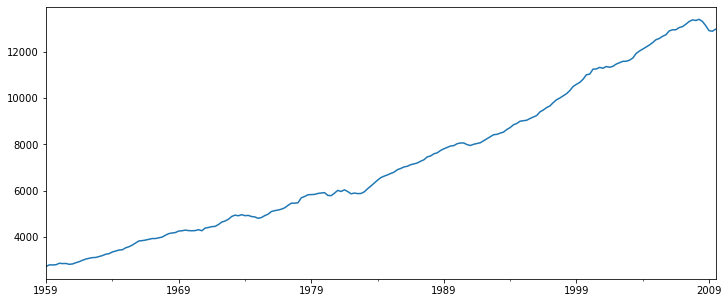

In [7]:
df.realgdp.plot(figsize=(12,5));

# Trends and Cyclicity

Hodrick Prescott filter seperates out the trend and cyclicity in a time series

In [9]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [10]:
gdp_cycle,gdp_trend=hpfilter(df.realgdp,lamb=1600)

In [12]:
df['trend']=gdp_trend
df['cyclicity']=gdp_cycle

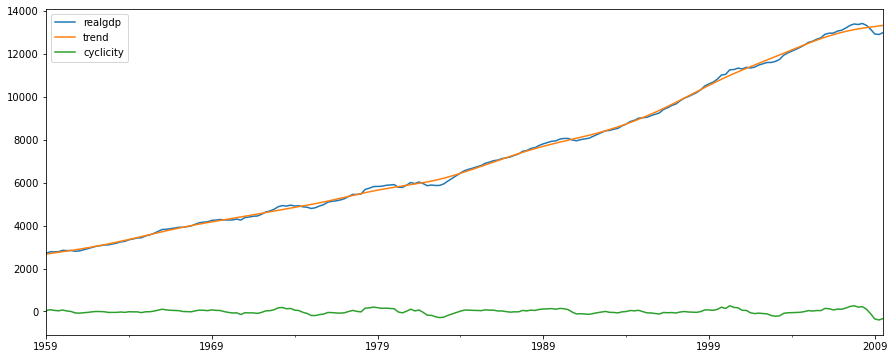

In [19]:
df[['realgdp','trend','cyclicity']].plot(figsize=(15,6));

# ETS Decomposition

In [22]:
airline=pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)

In [43]:
airline=airline.dropna()

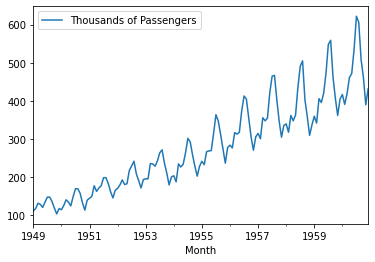

In [44]:
airline.plot()

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [74]:
result=seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')

In [81]:
#result.plot();

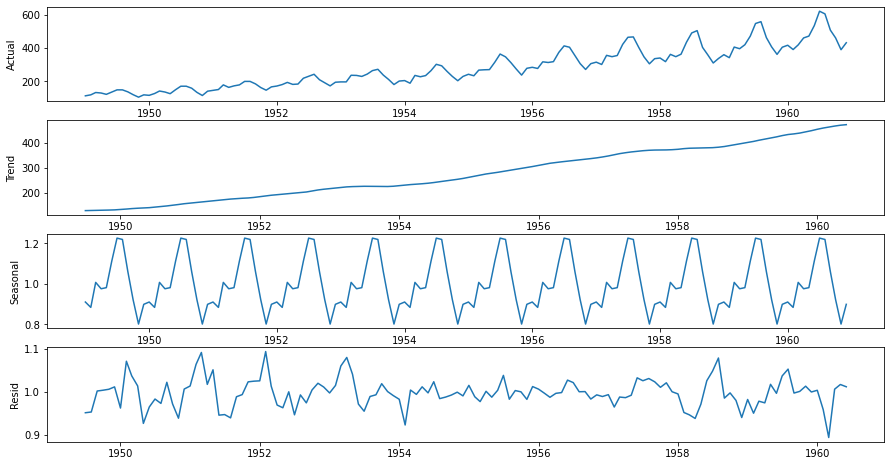

In [80]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(15,8))
#fig.suptitle('Decomposition')
ax1.plot(result.observed)
ax1.set(ylabel='Actual')
ax2.plot(result.trend)
ax2.set(ylabel='Trend')
ax3.plot(result.seasonal)
ax3.set(ylabel='Seasonal')
ax4.plot(result.resid)
ax4.set(ylabel='Resid');

# EWMA

In [82]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [84]:
airline['6_month_SMA']=airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12_month_SMA']=airline['Thousands of Passengers'].rolling(window=12).mean()

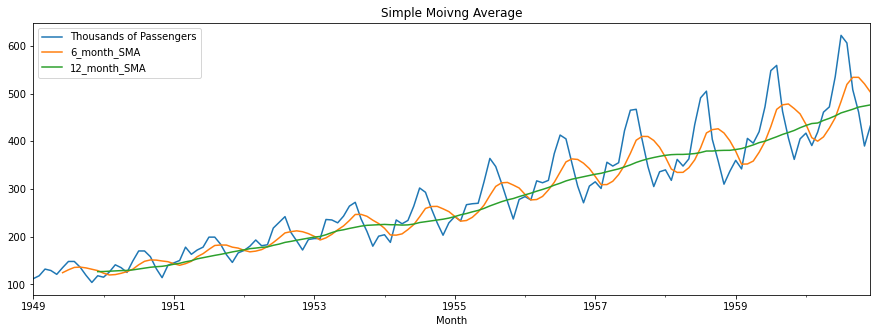

In [87]:
airline.plot(figsize=(15,5))
plt.title('Simple Moivng Average');

In [90]:
airline['12_EWMA']=airline['Thousands of Passengers'].ewm(span=12).mean()

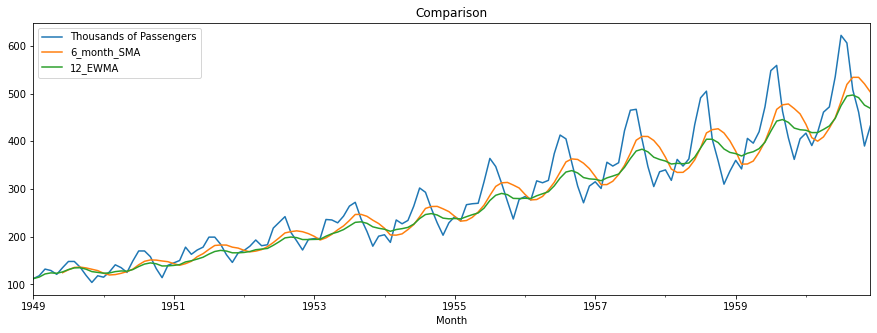

In [94]:
airline[['Thousands of Passengers','6_month_SMA','12_EWMA']].plot(figsize=(15,5))
plt.title('Comparison');

In EWMA... the lag is reduced because more weights are given to recent data

# Holt-Winters Method

In [95]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [110]:
span=12
alpha=2/(span+1)
model=SimpleExpSmoothing(airline['Thousands of Passengers'])

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [104]:
fitted_model=model.fit(smoothing_level=alpha,
    optimized=False)

In [115]:
airline['SEM_12']=fitted_model.fittedvalues.shift(-1)  #shift(-1) because of optimization FALSE

In [112]:
airline['12_EWMA']

Month
1949-01-01    112.000000
1949-02-01    115.250000
1949-03-01    121.787529
1949-04-01    124.064224
1949-05-01    123.231685
                 ...    
1960-08-01    494.898620
1960-09-01    496.914217
1960-10-01    491.388952
1960-11-01    475.790652
1960-12-01    469.053629
Name: 12_EWMA, Length: 144, dtype: float64

In [116]:
airline['SEM_12']

Month
1949-01-01    112.000000
1949-02-01    112.923077
1949-03-01    115.857988
1949-04-01    117.879836
1949-05-01    118.359861
                 ...    
1960-08-01    494.898619
1960-09-01    496.914216
1960-10-01    491.388952
1960-11-01    475.790652
1960-12-01           NaN
Name: SEM_12, Length: 144, dtype: float64

### Double Exponential Smoothing or Holts Method

In [118]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Additive model

In [119]:
airline['DES_add_12']=ExponentialSmoothing(airline['Thousands of Passengers'],trend='add').fit().fittedvalues.shift(-1)

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


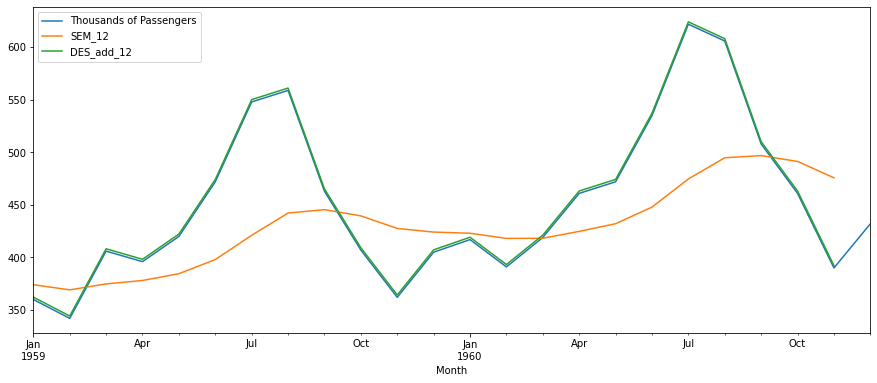

In [126]:
airline[['Thousands of Passengers','SEM_12', 'DES_add_12']].iloc[-24:].plot(figsize=(15,6));

The  Double Exponential Smoothing predicts very close to the Actial value. It can only be seen if we zoom in. The later part fits better than the initial part

#### Multiplicative model

In [127]:
airline['DES_mul_12']=ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul').fit().fittedvalues.shift(-1)

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


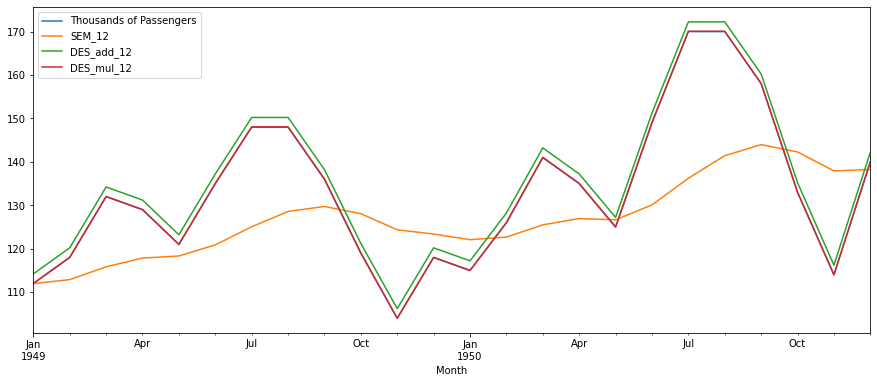

In [129]:
airline[['Thousands of Passengers','SEM_12', 'DES_add_12','DES_mul_12']].iloc[:24].plot(figsize=(15,6));

Holts Multiplicative Model fits better for initial stage as well and fits better than additive model. It proves that the trend is increasing and not constant

In [132]:
airline['TES_mul_12']=ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


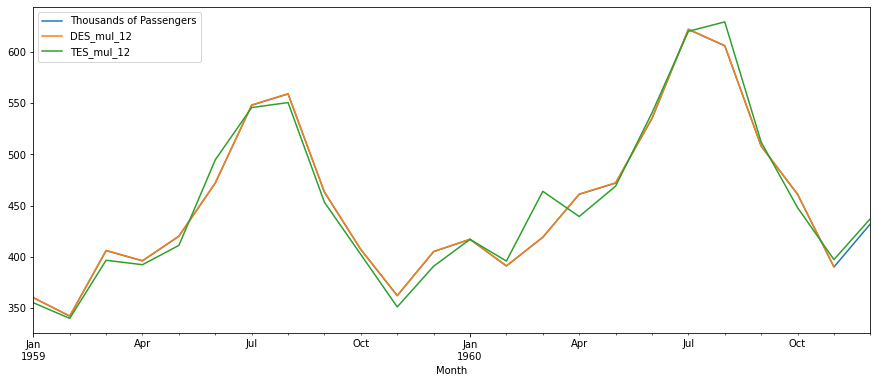

In [138]:
airline[['Thousands of Passengers','DES_mul_12','TES_mul_12']].iloc[-24:].plot(figsize=(15,6));